# Game: Reversi

## 1. Rules

This two-player board game is played on a grid, so we'll use a Cartesian coordinate system with x- and y-coordinates. We will incorporate an AI.

## 2. Flowchart

Below, we will only design the flow chart of the first mode of the game where the player is offered to play against the AI computer.

In [1]:
from graphviz import Digraph

In [2]:
dot = Digraph(comment='Reversi Flowchart')

dot.node('START', 'START', shape='oval', style='filled', fillcolor='grey')
dot.node("Ask for Player's tile", "Ask for \n Player's tile")
dot.node('Decide who Goes First', 'Decide who \n Goes First')

dot.node('Check if Stalemate', 'Check if \n Stalemate', style='filled', fillcolor='white')
dot.node('Check Score', 'Check \n Score', style='filled', fillcolor='white')
player_wins = Digraph('Player wins', node_attr={'shape': 'doublecircle', 'color': 'green', 'style': 'filled', 'fillcolor': 'white'})
player_wins.node('Win','Win')
dot.subgraph(player_wins)
nobody_wins = Digraph('Nobody wins', node_attr={'shape': 'doublecircle', 'color': 'blue', 'style': 'filled', 'fillcolor': 'white'})
nobody_wins.node('Tie','Tie')
dot.subgraph(nobody_wins)
computer_wins = Digraph('Computer wins', node_attr={'shape': 'doublecircle', 'color': 'red', 'style': 'filled', 'fillcolor': 'white'})
computer_wins.node('Lose','Lose')
dot.subgraph(computer_wins)

dot.node('Who\'s turn?', 'Who\'s turn?', style='filled', fillcolor='white')
dot.node('Check if Hint requested', 'Check if \n Hint \n requested', style='filled', fillcolor='white')
dot.node('Display Board with Valid Moves', 'Display \n board with \n Valid Moves', style='filled', fillcolor='white')
dot.node('Display Board_p', 'Display Board', style='filled', fillcolor='white')
dot.node("Ask for Player's Move", "Ask for Player's Move", style='filled', fillcolor='white')
dot.node('Display Board_c', 'Display Board', style='filled', fillcolor='white')
dot.node("Get Computer's Best Move", "Get Computer's \n Best Move", style='filled', fillcolor='white')

dot.node('Play Again?', 'Play Again?', style='filled', fillcolor='white')
dot.node('END', 'END', shape='oval', style='filled', fillcolor='grey')

In [3]:
dot.edge('START', "Ask for Player's tile")
dot.edge("Ask for Player's tile", 'Decide who Goes First')
dot.edge('Decide who Goes First', 'Check if Stalemate')

with dot.subgraph(name="cluster_stalemate") as s:
    s.attr(style='filled', color='lightgrey')
    s.edge('Check if Stalemate', 'Check Score', label='No more \n valid moves left')
    s.edge('Check Score', 'Win', label='Player \n wins')
    s.edge('Check Score', 'Tie', label='It\'s a tie')
    s.edge('Check Score', 'Lose', label='Computer \n wins')
    s.attr(label='Check Winning Condition')
    
dot.edge('Check if Stalemate', 'Who\'s turn?', label='Valid moves \n still remaining')

dot.edge('Who\'s turn?', 'Check if Hint requested')
with dot.subgraph(name="cluster_player") as p:
    p.attr(style='filled', color='lightgrey')
    p.edge('Check if Hint requested', 'Display Board with Valid Moves', label='Yes')
    p.edge('Display Board with Valid Moves', "Ask for Player's Move")
    p.edge('Check if Hint requested', 'Display Board_p', label='No')
    p.edge('Display Board_p', "Ask for Player's Move")
    
    p.edge("Ask for Player's Move", 'Display Board with Valid Moves', label='Move = hint')
    p.edge("Ask for Player's Move", 'Check if Stalemate', label='Move = xy')
    p.attr(label="Player's Turn")
    
dot.edge('Who\'s turn?', 'Display Board_c')
with dot.subgraph(name="cluster_computer") as c:
    c.attr(style='filled', color='lightgrey')
    c.edge('Display Board_c', "Get Computer's Best Move")
    c.edge("Get Computer's Best Move", "Check if Stalemate")
    c.attr(label="Computer's Turn")

dot.edge("Ask for Player's Move", 'END', label='Move = quit')
dot.edge('Win', 'Play Again?')
dot.edge('Tie', 'Play Again?')
dot.edge('Lose', 'Play Again?')
dot.edge('Play Again?', 'Decide who Goes First', label='Yes')
dot.edge('Play Again?', 'END', label='No')

### MODE 1

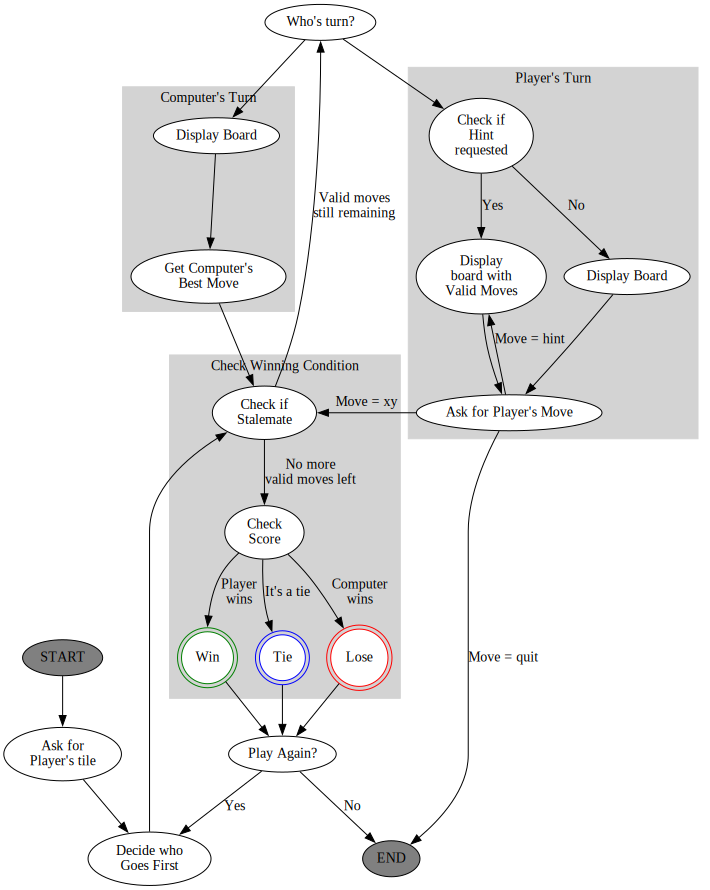

In [4]:
dot

## 3. Program

In [5]:
# Importing modules and setting up constants
import random
import sys
WIDTH = 8  # Board is 8 spaces wide
HEIGHT = 8 # Board is 8 spaces tall

# Setting constants to play the AI several times
NUM_GAMES = 250
xWins = oWins = ties = 0

In [6]:
# Function asks for the mode the player wants to play
def selectMode():
    gamemode=''
    while not (gamemode == '1' or gamemode == '2'):
        print('''Select the mode you want to play:
        mode 1: you play against the computer
        mode 2: you make the computer AIs compete against each other''')
        gamemode = input()
        
    if gamemode == '1':
        competitor='P'
        while competitor not in ('PB','PW','PR'):
            print('''Who do you want to compete against?
            B: AI selects the best moves
            W: AI selects the worst moves 
            R: AI selects random moves''')
            competitor += input().upper()
            
    if gamemode == '2':
        competitor=''
        while competitor not in ('BB','BW','BR','WB','WW','WR','RB','RW','RR'):
            print('''Which computer AIs do you want to see compete against?
            B: AI selects the best moves
            W: AI selects the worst moves 
            R: AI selects random moves
            Select a pair. For instance "BR"''')
            competitor = input().upper()

    return competitor

In [7]:
# Function lets the player type which tile he wants to be.
# Returns a list with the player's tile as the first item and the computer's tile as the second.
def enterPlayerTile():
    tile = ''
    while not (tile == 'X' or tile == 'O'):
        print('Do you want to be X or O?')
        tile = input().upper()

    # The first element in the list is the player's tile, and the second is the computer's tile.
    if tile == 'X':
        return ['X', 'O']
    else:
        return ['O', 'X']

In [8]:
# Function randomly chooses who goes first.
def whoGoesFirst():
    if random.randint(0, 1) == 0:
        return 'computer'
    else:
        return 'player'

In [9]:
# Function creates a brand-new, blank board data structure.
def getNewBoard():
    board = []
    for i in range(WIDTH):
        board.append([' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '])
    return board

In [10]:
# Function returns True if the coordinates are located on the board.
def isOnBoard(x, y):
    return x >= 0 and x <= WIDTH - 1 and y >= 0 and y <= HEIGHT - 1

In [11]:
# Function checks whether a move is valid.

# The call to the isValidMove() function either returns the Boolean value False or a nonempty list:
## If the player's move is not valid: returns False.
## If the player's move is valid: returns a list of spaces that would be flipped.

def isValidMove(board, tile, xstart, ystart):
    # For a move to be valid, space must be empty + move must be on the board
    if board[xstart][ystart] != ' ' or not isOnBoard(xstart, ystart):
        return False

    if tile == 'X':
        otherTile = 'O'
    else:
        otherTile = 'X'
    
    # Store all the tiles coordinates
    tilesToFlip = []
    # Check each of the 8 directions
    for xdirection, ydirection in [[0, 1], [1, 1], [1, 0], [1, -1], [0, -1], [-1, -1], [-1, 0], [-1, 1]]:
        x, y = xstart, ystart
        x += xdirection # First step in the x direction
        y += ydirection # First step in the y direction
        while isOnBoard(x, y) and board[x][y] == otherTile:
            # Keep moving in this x & y direction.
            x += xdirection
            y += ydirection
            # If there are pieces to flip over.
            if isOnBoard(x, y) and board[x][y] == tile:
                # Go in the reverse direction until we reach the original space, noting all the tiles along the way.
                while True:
                    x -= xdirection
                    y -= ydirection
                    if x == xstart and y == ystart:
                        break
                    tilesToFlip.append([x, y])

    # For a move to be valid, at least one tile must be flipped.                
    if len(tilesToFlip) == 0:
        return False
    return tilesToFlip

In [12]:
# Function makes a duplicate of the board list and return it.
def getBoardCopy(board):
    boardCopy = getNewBoard()

    for x in range(WIDTH):
        for y in range(HEIGHT):
            boardCopy[x][y] = board[x][y]

    return boardCopy

In [13]:
# Function returns a list of [x,y] lists of valid moves for the given player on the given board.
def getValidMoves(board, tile):
    validMoves = []
    for x in range(WIDTH):
        for y in range(HEIGHT):
            if isValidMove(board, tile, x, y) != False:
                validMoves.append([x, y])
    return validMoves

In [14]:
# Function returns a new board with periods marking the valid moves the player can make.
def getBoardWithValidMoves(board, tile):
    boardCopy = getBoardCopy(board)

    for x, y in getValidMoves(boardCopy, tile):
        boardCopy[x][y] = '.'
    return boardCopy

In [15]:
# Function draws the board data strcuture on the screen
def drawBoard(board):
    print('  12345678')
    print(' +--------+')
    for y in range(HEIGHT):
        print('%s|' % (y+1), end='')
        for x in range(WIDTH):
            print(board[x][y], end='')
        print('|%s' % (y+1))
    print(' +--------+')
    print('  12345678')

In [16]:
# Function determines the score by counting the tiles. 
# Returns a dictionary with keys 'X' and 'O'.
def getScoreOfBoard(board):
    xscore = 0
    oscore = 0
    for x in range(WIDTH):
        for y in range(HEIGHT):
            if board[x][y] == 'X':
                xscore += 1
            if board[x][y] == 'O':
                oscore += 1
    return {'X':xscore, 'O':oscore}

In [17]:
# Function prints the score in the board
def printScore(board, playerTile, computerTile):
    scores = getScoreOfBoard(board)
    print('You: %s points. Computer: %s points.' % (scores[playerTile], scores[computerTile]))

In [18]:
# MODE 1 only
# Function lets the player enter his move.
# Returns the move as [x, y] (or returns the strings 'hints' or 'quit').
def getPlayerMove(board, playerTile):
    DIGITS1TO8 = '1 2 3 4 5 6 7 8'.split()
    while True:
        print('Enter your move, "quit" to end the game, or "hints" to toggle hints.')
        move = input().lower()
        if move == 'quit' or move == 'hints':
            return move

        if len(move) == 2 and move[0] in DIGITS1TO8 and move[1] in DIGITS1TO8:
            x = int(move[0]) - 1
            y = int(move[1]) - 1
            if isValidMove(board, playerTile, x, y) == False:
                continue
            else:
                break
        else:
            print('That is not a valid move. Enter the column (1-8) and then the row (1-8).')
            print('For example, 81 will move on the top-right corner.')

    return [x, y]

In [19]:
# MODE B only: Computer selects best move
# Function returns True if the position is in one of the four corners.
def isOnCorner(x, y):
    return (x == 0 or x == WIDTH - 1) and (y == 0 or y == HEIGHT - 1)

In [20]:
# MODE B only: Computer selects best move
# Function determines where the computer should move.
# Returns the move as a [x, y] list.
def getBestComputerMove(board, tile):
    possibleMoves = getValidMoves(board, tile)
    random.shuffle(possibleMoves) # randomize the order of the moves

    # Always go for a corner if available.
    for x, y in possibleMoves:
        if isOnCorner(x, y):
            return [x, y]

    # Find the highest-scoring move possible.
    bestScore = -1
    for x, y in possibleMoves:
        boardCopy = getBoardCopy(board)
        makeMove(boardCopy, computerTile, x, y)
        score = getScoreOfBoard(boardCopy)[tile]
        if score > bestScore:
            bestMove = [x, y]
            bestScore = score
    return bestMove

In [21]:
# MODE W only: Computer selects worst move
# Function determines where the computer should move.
# Returns the move as a [x, y] list.
def getWorstComputerMove(board, tile):
    # Return the move that flips the least number of tiles.
    possibleMoves = getValidMoves(board, tile)
    random.shuffle(possibleMoves) # Randomize the order of the moves.

    # Go through all the possible moves and remember the best scoring move.
    worstScore = 64
    for x, y in possibleMoves:
        boardCopy = getBoardCopy(board)
        makeMove(boardCopy, tile, x, y)
        score = getScoreOfBoard(boardCopy)[tile]
        if score < worstScore:
            worstMove = [x, y]
            worstScore = score
    return worstMove

In [22]:
# MODE R only: Computer selects random move
# Function determines where the computer should move.
# Returns the move as a [x, y] list.
def getRandomComputerMove(board, tile):
    possibleMoves = getValidMoves(board, tile)
    return random.choice(possibleMoves)

In [23]:
# Function places the tile on the board at xstart, ystart, and flip any of the opponent's pieces.
# Returns False if this is an invalid move; True if it is valid.
def makeMove(board, tile, xstart, ystart):
    tilesToFlip = isValidMove(board, tile, xstart, ystart)

    if tilesToFlip == False:
        return False

    board[xstart][ystart] = tile
    for x, y in tilesToFlip:
        board[x][y] = tile
    return True

In [24]:
def playGame(playerTile, computerTile):
    showHints = False
    turn = whoGoesFirst()
    
    if competitor[0] == 'P':
        print('The ' + turn + ' will go first.')

    # Clear the board and place starting pieces.
    board = getNewBoard()
    board[3][3] = 'X'
    board[3][4] = 'O'
    board[4][3] = 'O'
    board[4][4] = 'X'

    while True:
        playerValidMoves = getValidMoves(board, playerTile)
        computerValidMoves = getValidMoves(board, computerTile)
        
        # Check for Stalemate
        if playerValidMoves == [] and computerValidMoves == []:
            # No one can move, so end the game.
            return board 
        
        # Player's turn
        elif turn == 'player': 
            if playerValidMoves != []:
                # Mode 1
                if competitor[0] == 'P':
                    if showHints:
                        validMovesBoard = getBoardWithValidMoves(board, playerTile)
                        drawBoard(validMovesBoard)
                    else:
                        drawBoard(board)
                    printScore(board, playerTile, computerTile)

                    move = getPlayerMove(board, playerTile)
                    if move == 'quit':
                        print('Thanks for playing!')
                        sys.exit() # Terminate the program.
                    elif move == 'hints':
                        showHints = not showHints
                        continue
                    else:
                        makeMove(board, playerTile, move[0], move[1])
                # Mode 2
                else:
                    if competitor[0] == 'B':
                        move = getBestComputerMove(board, playerTile)
                    elif competitor[0] == 'W':
                        move = getWorstComputerMove(board, playerTile)
                    elif competitor[0] == 'R':
                        move = getRandomComputerMove(board, playerTile)
                    makeMove(board, playerTile, move[0], move[1])
            turn = 'computer'
        
        # Computer's turn
        elif turn == 'computer': 
            if computerValidMoves != []:
                # Mode 1 computer turn introduction
                if competitor[0] == 'P':
                    drawBoard(board)
                    printScore(board, playerTile, computerTile)
                    input('Press Enter to see the computer\'s move.')
                # Mode 2: Bypass Mode 1 computer turn introduction
                if competitor[1] == 'B':
                    move = getBestComputerMove(board, computerTile)
                elif competitor[1] == 'W':
                    move = getWorstComputerMove(board, computerTile)
                elif competitor[1] == 'R':
                    move = getRandomComputerMove(board, computerTile)
                makeMove(board, computerTile, move[0], move[1])
            turn = 'player'

In [25]:
print('Welcome to Reversi!')

while True:
    competitor = selectMode()

    # Mode 1
    if competitor[0] == 'P':

        playerTile, computerTile = enterPlayerTile()

        finalBoard = playGame(playerTile, computerTile)

        # Display the final score.
        drawBoard(finalBoard)
        scores = getScoreOfBoard(finalBoard)
        print('X scored %s points. O scored %s points.' % (scores['X'], scores['O']))
        if scores[playerTile] > scores[computerTile]:
            print('You beat the computer by %s points! Congratulations!' % (scores[playerTile] - scores[computerTile]))
        elif scores[playerTile] < scores[computerTile]:
            print('You lost. The computer beat you by %s points.' % (scores[computerTile] - scores[playerTile]))
        else:
            print('The game was a tie!')

    # Mode 2
    else:

        playerTile, computerTile = ['X', 'O']
        # print('The tile X represents %s and the tile O represents %s.' % (competitor[0],competitor[1]))

        for i in range(NUM_GAMES):
            finalBoard = playGame(playerTile, computerTile)

            # Display the final score.
            scores = getScoreOfBoard(finalBoard)
            # print('#%s: X scored %s points. O scored %s points.' % (i + 1, scores['X'], scores['O']))
            if scores[playerTile] > scores[computerTile]:
                xWins += 1
            elif scores[playerTile] < scores[computerTile]:
                oWins += 1
            else:
                ties += 1

        print('%s wins: %s (%s%%)' % (competitor[0], xWins, round(xWins / NUM_GAMES * 100, 1)))
        print('%s wins: %s (%s%%)' % (competitor[1], oWins, round(oWins / NUM_GAMES * 100, 1)))
        print('Ties:   %s (%s%%)' % (ties, round(ties / NUM_GAMES * 100, 1)))
    
    print('Do you want to play again? (yes or no)')
    if not input().lower().startswith('y'):
        break

Welcome to Reversi!
Select the mode you want to play:
        mode 1: you play against the computer
        mode 2: you make the computer AIs compete against each other


 2


Which computer AIs do you want to see compete against?
            B: AI selects the best moves
            W: AI selects the worst moves 
            R: AI selects random moves
            Select a pair. For instance "BR"


 bw


B wins: 178 (71.2%)
W wins: 60 (24.0%)
Ties:   12 (4.8%)
Do you want to play again? (yes or no)


 yes


Select the mode you want to play:
        mode 1: you play against the computer
        mode 2: you make the computer AIs compete against each other


 2


Which computer AIs do you want to see compete against?
            B: AI selects the best moves
            W: AI selects the worst moves 
            R: AI selects random moves
            Select a pair. For instance "BR"


 wr


W wins: 265 (106.0%)
R wins: 215 (86.0%)
Ties:   20 (8.0%)
Do you want to play again? (yes or no)


 yes


Select the mode you want to play:
        mode 1: you play against the computer
        mode 2: you make the computer AIs compete against each other


 1


Who do you want to compete against?
            B: AI selects the best moves
            W: AI selects the worst moves 
            R: AI selects random moves


 b


Do you want to be X or O?


 X


The computer will go first.
  12345678
 +--------+
1|        |1
2|        |2
3|        |3
4|   XO   |4
5|   OX   |5
6|        |6
7|        |7
8|        |8
 +--------+
  12345678
You: 2 points. Computer: 2 points.


Press Enter to see the computer's move. 


  12345678
 +--------+
1|        |1
2|        |2
3|   O    |3
4|   OO   |4
5|   OX   |5
6|        |6
7|        |7
8|        |8
 +--------+
  12345678
You: 1 points. Computer: 4 points.
Enter your move, "quit" to end the game, or "hints" to toggle hints.


 hints


  12345678
 +--------+
1|        |1
2|        |2
3|  .O.   |3
4|   OO   |4
5|  .OX   |5
6|        |6
7|        |7
8|        |8
 +--------+
  12345678
You: 1 points. Computer: 4 points.
Enter your move, "quit" to end the game, or "hints" to toggle hints.


 33


  12345678
 +--------+
1|        |1
2|        |2
3|  XO    |3
4|   XO   |4
5|   OX   |5
6|        |6
7|        |7
8|        |8
 +--------+
  12345678
You: 3 points. Computer: 3 points.


Press Enter to see the computer's move. 


  12345678
 +--------+
1|        |1
2|        |2
3|  XO.   |3
4|  OOO   |4
5|  .OX   |5
6|        |6
7|        |7
8|        |8
 +--------+
  12345678
You: 2 points. Computer: 5 points.
Enter your move, "quit" to end the game, or "hints" to toggle hints.


 quit


Thanks for playing!


SystemExit: 

C:\Users\pauly\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 4. Notes

### 4.1. The boolean function

Python bool() function is used to return or convert a value to a Boolean value i.e., True or False, using the standard truth testing procedure.

In [ ]:
one = bool(0)
two = bool (1)
print("one: ",one," two: ",two)

In [ ]:
one = bool('')
two = bool('Hello')
print("one: ",one," two: ",two)

In [ ]:
one = bool([])
two = bool([1,2,3,4,5])
print("one: ",one," two: ",two)

In [ ]:
one = bool({})
two = bool ({'spam':'cheese','fizz':'buzz'})
print("one: ",one," two: ",two)

The call to the isValidMove() function either returns the Boolean value False or a nonempty list.